In [ ]:
## *MITx Project 4*

In [2]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy import interpolate

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.eval_measures import rmse



## *2. The Mauna Loa CO_2 Concentration*

In [3]:
#Read the data and drop invalide entries indicated by the value -99.99
co2_df = pd.read_csv('./release_time_series_report_data/CO2.csv', skiprows=57, usecols=[0,1,3,4], names=['Year','Month','Date','CO2'])
co2_df['Period'] = co2_df['Date']-1958
co2_df = co2_df[co2_df['CO2']!=-99.99]
co2_df.head


<bound method NDFrame.head of      Year  Month       Date     CO2   Period
2    1958      3  1958.2027  315.70   0.2027
3    1958      4  1958.2877  317.45   0.2877
4    1958      5  1958.3699  317.51   0.3699
6    1958      7  1958.5370  315.86   0.5370
7    1958      8  1958.6219  314.93   0.6219
..    ...    ...        ...     ...      ...
736  2019      5  2019.3699  414.83  61.3699
737  2019      6  2019.4548  413.96  61.4548
738  2019      7  2019.5370  411.85  61.5370
739  2019      8  2019.6219  410.08  61.6219
740  2019      9  2019.7068  408.55  61.7068

[734 rows x 5 columns]>

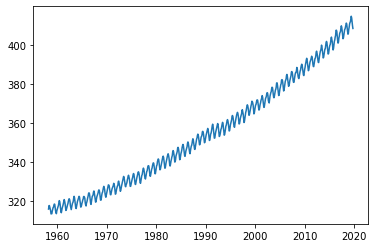

In [4]:
#Plot the data set
plt.plot(co2_df['Date'],co2_df['CO2'])

In [5]:
#Looks like seasonal variation, with increasing trend but not necessarily linear trend (maybe linear after a log tranform)

In [6]:
#Set the training split and get the count of training data points.
train_pct = 0.80
train_count = int(co2_df.shape[0] * train_pct)

#Split the data set into training and test sets
X_train = [[Period] for Period in co2_df['Period'][:train_count]]
Y_train = [[CO2] for CO2 in co2_df['CO2'][:train_count]]
X_test = [[Period] for Period in co2_df['Period'][train_count:]]
Y_test = [[CO2] for CO2 in co2_df['CO2'][train_count:]]

In [7]:
reg = LinearRegression().fit(X_train,Y_train) 
#reg.score(X_train,Y_train)
print("Slope: ", reg.coef_, " Intercept:", reg.intercept_)

Slope:  [[1.40668098]]  Intercept: [308.99546949]


In [8]:
Y_train_predict = reg.predict(X_train)
#Calculate the residuals, defined as the actual value - the predicted
Y_train_residuals = Y_train - Y_train_predict

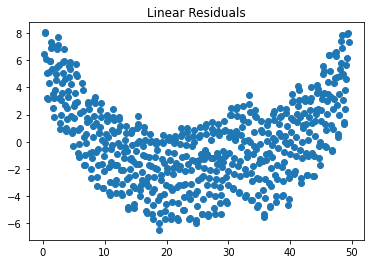

In [9]:
#Plot the residuals
plt.title("Linear Residuals")
plt.scatter(X_train, Y_train_residuals)

In [10]:
#Now predict values for the test set
Y_test_predict = reg.predict(X_test)

#Calculate the root means squared error and the mean absolute pct error 
RMSE = mean_squared_error(Y_test, Y_test_predict, squared=False)
MAPE = mean_absolute_percentage_error(Y_test, Y_test_predict)
print("RMSE: ", RMSE, " MAPE: ", MAPE)

RMSE:  10.642011413148976  MAPE:  0.024505275995447513


In [11]:
#Given the shape of the residuals and the poor RMSE and MAPE results from the linear model, lets try a quadratic model
#PolynomialFeatures and the make_pipeline should help simplify the process
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [12]:
#Start with a quadratic model (2nd order) and then fit it 
degree=2
quadreg=PolynomialFeatures(degree)
X_train_quad = quadreg.fit_transform(X_train)

linreg = LinearRegression()
linreg.fit(X_train_quad, Y_train)

Y_quad_predict = linreg.predict(X_train_quad)

#Print our fitted quadratic coefficients and intercept
print("Coefs: ", linreg.coef_, " Intercept: ", linreg.intercept_)

Coefs:  [[0.         0.80213511 0.01211779]]  Intercept:  [314.10295065]


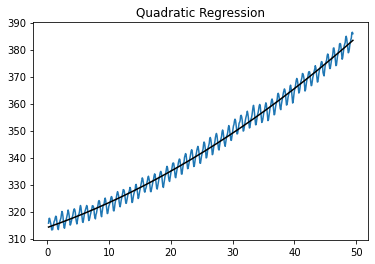

In [13]:
#Let's plot the fitted quadratic model
plt.figure()
plt.plot(X_train,Y_train)
plt.plot(X_train,Y_quad_predict,color="black")
plt.title("Quadratic Regression")
plt.show()

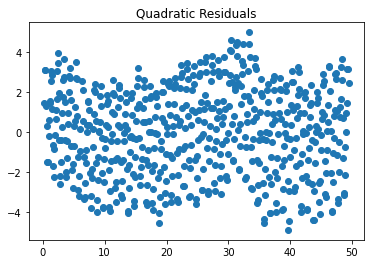

In [14]:
#Now lets calculate and look at the residuals for the quadratic model
quad_train_residuals = Y_train - Y_quad_predict
plt.title("Quadratic Residuals")
plt.scatter(X_train, quad_train_residuals)

In [15]:
#Now predict quadratic values for the transformed test set
X_test_quad = quadreg.transform(X_test)
Y_test_quad_predict = linreg.predict(X_test_quad)

#Calculate our coefficients, the RMSE and MASE
Quad_RMSE = mean_squared_error(Y_test, Y_test_quad_predict, squared=False)
Quad_MAPE = mean_absolute_percentage_error(Y_test, Y_test_quad_predict)
print("Quadratic RMSE: ", Quad_RMSE, " Quadratic MAPE: ", Quad_MAPE)

Quadratic RMSE:  2.5028073719222728  Quadratic MAPE:  0.005322789167375787


In [16]:
#Next try a cubic model (2nd order) and then fit it 
degree = 3
cubereg = PolynomialFeatures(degree)
X_train_cube = cubereg.fit_transform(X_train)

linreg2 = LinearRegression()
linreg2.fit(X_train_cube, Y_train)

Y_cube_predict = linreg2.predict(X_train_cube)

#Print our cubic fitted coefficients and intercept:
print("Coefs: ", linreg2.coef_, " Intercept: ", linreg2.intercept_)

Coefs:  [[ 0.00000000e+00  6.24869938e-01  2.09624454e-02 -1.18397534e-04]]  Intercept:  [314.86089144]


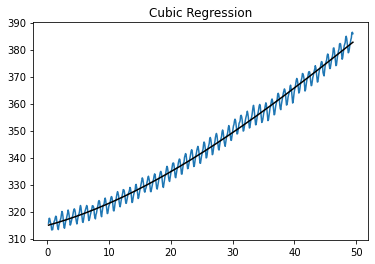

In [17]:
#Let's plot the fitted cubic model
plt.figure()
plt.plot(X_train,Y_train)
plt.plot(X_train,Y_cube_predict,color="black")
plt.title("Cubic Regression")
plt.show()

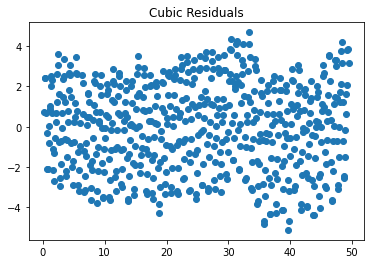

In [18]:
#Now lets calculate and look at the residuals for the quadratic model
cube_train_residuals = Y_train - Y_cube_predict
plt.title("Cubic Residuals")
plt.scatter(X_train, cube_train_residuals)

In [19]:
#Now predict cubic values for the transformed test set
X_test_cube = cubereg.transform(X_test)
Y_test_cube_predict = linreg2.predict(X_test_cube)

#Calculate our coefficients, the RMSE and MASE
Cube_RMSE = mean_squared_error(Y_test, Y_test_cube_predict, squared=False)
Cube_MAPE = mean_absolute_percentage_error(Y_test, Y_test_cube_predict)
print("Cubic RMSE: ", Cube_RMSE, " Cubic MAPE: ", Cube_MAPE)

Cubic RMSE:  4.151525341775371  Cubic MAPE:  0.00848734285315907


In [29]:
MonthAvg = np.zeros(12)
MonthAvgDict = {}

for i in range(0,12):
    MonthIdx = np.where(co2_df['Month'][:train_count]==(i+1))[0]
    MonthAvg[i] = np.mean(quad_train_residuals[MonthIdx])
    MonthAvgDict[i+1]=MonthAvg[i]

print('January average residual:', MonthAvg[0], 'February average residual:', MonthAvg[1])
#print(MonthAvgDict)

January average residual: -0.01564690643915142 February average residual: 0.6414997031065065
{1: -0.01564690643915142, 2: 0.6414997031065065, 3: 1.359242937805725, 4: 2.5632808491385015, 5: 2.98593405288031, 6: 2.3173924398469348, 7: 0.7788375666291173, 8: -1.3007909430792384, 9: -3.1297776152284107, 10: -3.309527660517715, 11: -2.0837362705510993, 12: -0.9220951333934119}


## *The Mauna Loa CO_2 Concentration Written Report Section* 

## 2.1 Plot the periodic signal 

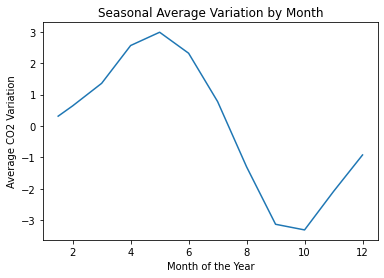

In [21]:
#Plot the interpolated seasonal variance averages
f = interpolate.interp1d(np.arange(1,13), MonthAvg)
x_interp = np.arange(1.5,12.5,0.5)

plt.title('Seasonal Average Variation by Month')
plt.xlabel('Month of the Year')
plt.ylabel('Average CO2 Variation')
plt.plot(x_interp, f(x_interp))


In [31]:
co2_df['Season_Var']=co2_df['Month'].map(MonthAvgDict)
co2_df.head

<bound method NDFrame.head of      Year  Month       Date     CO2   Period  Season_Var
2    1958      3  1958.2027  315.70   0.2027    1.359243
3    1958      4  1958.2877  317.45   0.2877    2.563281
4    1958      5  1958.3699  317.51   0.3699    2.985934
6    1958      7  1958.5370  315.86   0.5370    0.778838
7    1958      8  1958.6219  314.93   0.6219   -1.300791
..    ...    ...        ...     ...      ...         ...
736  2019      5  2019.3699  414.83  61.3699    2.985934
737  2019      6  2019.4548  413.96  61.4548    2.317392
738  2019      7  2019.5370  411.85  61.5370    0.778838
739  2019      8  2019.6219  410.08  61.6219   -1.300791
740  2019      9  2019.7068  408.55  61.7068   -3.129778

[734 rows x 6 columns]>

In [32]:
#Get the average seasonal variations by month for the training set and the test set periods
Y_train_season = [[CO2] for CO2 in co2_df['Season_Var'][:train_count]]
Y_test_season = [[CO2] for CO2 in co2_df['Season_Var'][train_count:]]

In [33]:
#Construct the full model using the earlier quadratic model regressions plus the seasonal variations
Y_model_train = Y_quad_predict + Y_train_season
Y_model_test =  Y_test_quad_predict + Y_test_season


## 2.2: Plot the final fit $F_n(t_i) + P_i$

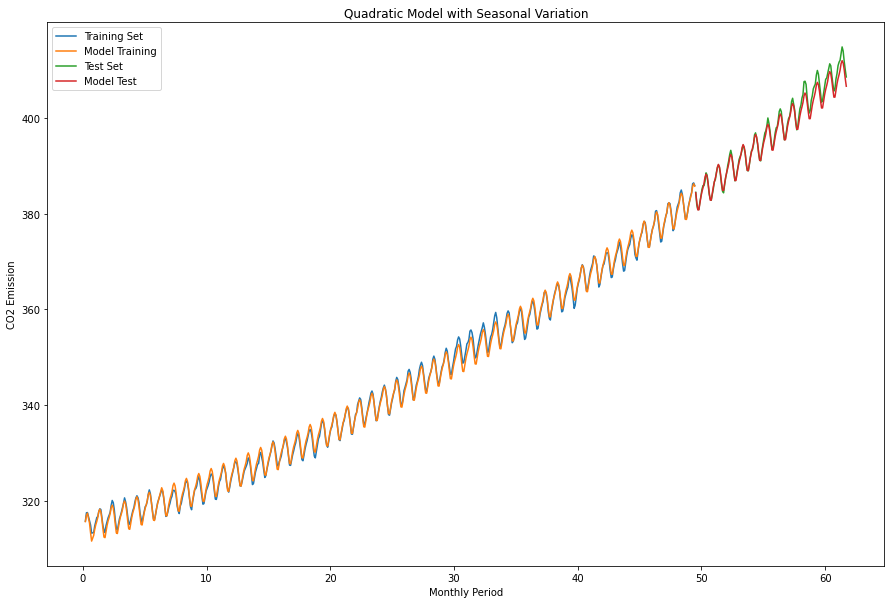

In [49]:
#Plot the orginal series and the model series for both the training and test periods
plt.figure(figsize=(15, 10))
plt.title("Quadratic Model with Seasonal Variation")
plt.xlabel("Monthly Period")
plt.ylabel("CO2 Emission")
plt.plot(X_train, Y_train, label='Training Set')
plt.plot(X_train, Y_model_train, label='Model Training')
plt.plot(X_test, Y_test, label='Test Set')
plt.plot(X_test, Y_model_test, label='Model Test')
plt.legend()

## 2.3: Report the root mean squared prediction error RMSE and the mean absolute percentage error MAPE with respect to the test set for this final model. Is this an improvement over the previous model $F_n(t_i) without the periodic signal?

In [51]:
#Print the RMSE and MAPE for the full model on the test periods, and print the earlier quadratic model RMSE and MAPE
Model_RMSE = mean_squared_error(Y_test, Y_model_test, squared=False)
Model_MAPE = mean_absolute_percentage_error(Y_test, Y_model_test)
print("Full Seasonal Model RMSE: ", Model_RMSE, " Full Seasonal Model MAPE: ", Model_MAPE)
print("Quadratic RMSE: ", Quad_RMSE, " Quadratic MAPE: ", Quad_MAPE)

Full Seasonal Model RMSE:  1.1494268931753475  Full Seasonal Model MAPE:  0.0020861963854737326
Quadratic RMSE:  2.5028073719222728  Quadratic MAPE:  0.005322789167375787


Above we see that the full model with seasonal variations provides a good visual fit of the training and test data, which is supported by the improved RMSE and MAPE values when compared with the quadratic model (which excludes the seasonal variation)

## 2.4 What is the ratio of the range of values of F to the amplitude of $P_i$ and the ratio of the amplitude of $P$ to the range of the residual $R_i$ (from removing both the trend and the periodic signal)? Is this decomposition of the variation of the CO2 concentration meaningful?

In [72]:
Fmin = np.min(Y_model_train)
Fmax = np.max(Y_model_test)
Frange = Fmax-Fmin

Pmax = MonthAvg.max()
Pmin = MonthAvg.min()
Pamp = Pmax-Pmin

Model_Residuals_Train = Y_train - Y_model_train
Model_Residuals_Test = Y_test - Y_model_test
Model_Residuals = np.append(Model_Residuals_Train, Model_Residuals_Test)
Rmax = np.max(Model_Residuals)
Rmin = np.min(Model_Residuals)
Rrange = Rmax-Rmin

print("F min:", Fmin, " F max:", Fmax, 'F range:', Frange)  
print('Avg Seasonal Max:', Pmax, 'Avg Seasonal Min:', Pmin, 'Avg Seasonal Range:', Pamp)
print("R min:", Rmin, " R max:", Rmax, 'R range:', Rrange )  

F min: 311.5461757750086  F max: 411.95463826973923 F range: 100.40846249473066
Avg Seasonal Max: 2.98593405288031 Avg Seasonal Min: -3.309527660517715 Avg Seasonal Range: 6.295461713398025
R min: -1.738661597664759  R max: 2.9752933041523306 R range: 4.71395490181709


Above we find the range of CO2 emissions increases by about 100 over a 5 year period, or roughly 20 per year (albeit not linearly).  We also find the average range of seasonal variation is approximately +/- 3 per year, which in the context of the general trend of 20 per year, is meaningful: (+/-) 3 / 20 is approximately +/- 15% depending on seaonality.

Looking at the residuals values across the full train/test model, we find a range of 4.7 (-1.7 to +3.0), and also find that average range of seasonal variation of +/- 3 is very meaningful relative to these residuals  

## 3. Autocovariance Functions

Consider the MA(1) model $X_t=W_t + \theta W_{t−1}$ where $W_t∼W∼N(0,\sigma^2)$. Find the autocovariance function of $X_t$.

Autocovariance $\gamma_X(k)$ is expressed as $\gamma_X(t,t-k)$ and is defined as $Cov(X_t, X_{t-k})$

For $k=0$, our autocovariance $\gamma_X(0) = Cov(X_t,X_t) = Var(X_t)$

$\gamma_X(0) = Var(X_t) = E(X_t - E(X_t))^2 = E(X_t^2 + 2 X_t * E(X_t) + E(X_t)^2)$ 

$E(X_t) = E(W_t + \theta W_{t-1}) = E(W_t) + \theta E(W_{t-1}) = E(N(0,\sigma ^2)) + \theta E(N(0,\sigma ^2)) = 0$

From above, $\gamma_X(0)$ simplifies to $E(X_t^2)$

$\gamma_X(0) = E(X_t^2) = E(W_t + \theta W_{t-1})^2  = E(W_t^2 + 2 \theta W_t W_{t-1} + (\theta W_{t-1})^2)$ 

$\gamma_X(0) = E(W_t^2) + E(2 \theta W_t W_{t-1}) + \theta^2 E(W_{t-1})$ and $E(2 \theta W_t W_{t-1}) = 0$ which simplifies to  

$\gamma_X(0) = E(W_t^2) + 0 + \theta^2 E(W_{t-1})$

By the definition of $W_t$, $E(W_t^2) = E(W_{t-1}^2) = \sigma_w^2$ and subsituting above, we have:

## *$\gamma_X(0) = (1 + \theta^2) \sigma_w^2$*


Next For $k=1$, our autocovariance $\gamma_X(1)$ = $Cov(X_t,X_{t-1}) = E((X_t)(X_{t-1}))$

$\gamma_X(1) = E((X_t)(X_{t-1})) = E((W_t + \theta W_{t-1})(W_{t-1} + \theta W_{t-2}))$

$\gamma_X(1) = E(W_t W_{t-1} + \theta W_t W_{t-2} + \theta W_{t-1}^2 + \theta^2 W_{t-1} W_{t-2}))$

$\gamma_X(1) = E(W_t W_{t-1}) + \theta E(W_t W_{t-2}) + \theta E(W_{t-1}^2) + \theta^2 E(W_{t-1} W_{t-2})$

And $E(W_t) = E(W_{t-1}) = E(W_{t-2}) = E(N(0, \sigma^2)) = 0$ leaving

$E(W_t W_{t-1}) = E(W_t W_{t-2}) = E(W_{t-1} W_{t-2}) = 0 $ and simplifying 

$\gamma_X(1) = \theta E(W_{t-1}^2) $

## *$\gamma_X(1) = \theta \sigma_w^2$*

And by definition, for an MA(1) model, $\gamma_X(q>1) = 0$

## *$\gamma_X(2) = 0$*

## 4. Billion Prices Project Data Analysis



In [172]:
#Read the datafile 
#set the datetype for datetime

price_df = pd.read_csv('./release_time_series_report_data/PriceStats_CPI.csv', header=0)
price_df['date'] = pd.to_datetime(price_df['date'])
price_df.head

<bound method NDFrame.head of            date  PriceStats    CPI
0    2008-07-24   100.00000  100.0
1    2008-07-25    99.99767  100.0
2    2008-07-26    99.92376  100.0
3    2008-07-27    99.91537  100.0
4    2008-07-28    99.89491  100.0
...         ...         ...    ...
4117 2019-11-01   118.30850    NaN
4118 2019-11-02   118.30440    NaN
4119 2019-11-03   118.31480    NaN
4120 2019-11-04   118.30910    NaN
4121 2019-11-05   118.31170    NaN

[4122 rows x 3 columns]>

In [173]:
#Reduce the series to use only the first day of the month (monthly CPI)
#Validate the expected number of rows of date (1 + 11 years * 12 months + 4 partial year months)
price_monthly_df = price_df[(price_df['date'].dt.day==1) | (price_df['date']=='2008-07-24')]
price_monthly_df.head

<bound method NDFrame.head of            date  PriceStats        CPI
0    2008-07-24   100.00000  100.00000
8    2008-08-01    99.85761  100.52510
39   2008-09-01    99.65436  100.12380
69   2008-10-01    99.72428   99.98538
100  2008-11-01    97.99059   98.97539
...         ...         ...        ...
3994 2019-07-01   117.78350  117.05920
4025 2019-08-01   117.94860  117.25480
4056 2019-09-01   117.84700  117.24880
4086 2019-10-01   118.18270  117.34070
4117 2019-11-01   118.30850        NaN

[137 rows x 3 columns]>

<function matplotlib.pyplot.show(close=None, block=None)>

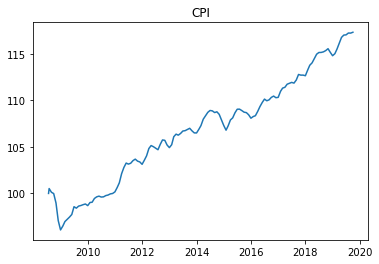

In [174]:
#Plot the data set
plt.title('CPI')
plt.plot(price_monthly_df['date'],price_monthly_df['CPI'])
plt.show

In [175]:
#Filter to values before September 2013
price_monthly_df_train = price_monthly_df[price_monthly_df['date'] < '2013-09-01']

#Reindex the date to monthly periods starting August 2008
#Reshape the data to numpy arrays for sklearn
X_train_cpi = ((price_monthly_df_train['date'].dt.year - 2008)*12 + price_monthly_df_train['date'].dt.month - 7).values.reshape(-1,1)
Y_train_cpi = price_monthly_df_train['CPI'].values.reshape(-1,1)

#Train a linear regressor on dates before September 2013
reg_cpi = LinearRegression().fit(X_train_cpi, Y_train_cpi) 
#reg.score(X_train,Y_train)
print("CPI Slope: ", reg_cpi.coef_, " CPI Intercept:", reg_cpi.intercept_)


CPI Slope:  [[0.16104348]]  CPI Intercept: [96.72932633]


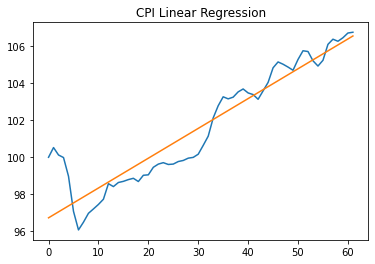

In [65]:
#Get the linear trend predicted values 
Y_predict_cpi = reg_cpi.predict(X_train_cpi)

plt.title('CPI Linear Regression')
plt.plot(X_train_cpi, Y_train_cpi)
plt.plot(X_train_cpi, Y_predict_cpi)

Maximum absolute value of CPI residuals:  3.634730187605456


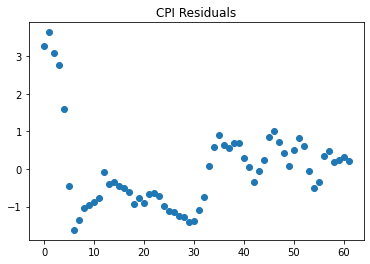

In [176]:
#Subtract these from the actual CPI to get the residual values
Residuals_cpi = Y_train_cpi - Y_predict_cpi

#Plot the residuals
plt.title("CPI Residuals")
plt.scatter(X_train_cpi, Residuals_cpi)

#Print the maximum absolute value
print('Maximum absolute value of CPI residuals: ', np.max(np.abs(Residuals_cpi)))

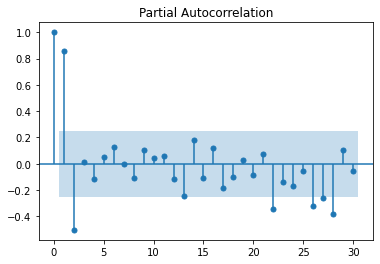

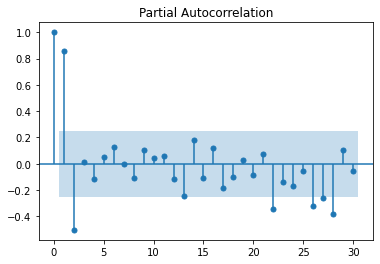

In [67]:
#Plot the Partial Autocorrelation Function of the detrended residuals
#Below we find the first two terms are significant, but those beyond that only show small amounts of noise
sm.graphics.tsa.plot_pacf(Residuals_cpi.squeeze(), lags=30)

In [177]:
#Fit a 2 degree autoregressive model on the residual CPI data
auto_reg_detrend = AutoReg(Residuals_cpi, lags=2, trend='n', old_names=False).fit()

#Print the fitted AR model parameters
print('Phi 0: ', auto_reg_detrend.params[0], 'Phi 1: ',  auto_reg_detrend.params[1])

Phi 0:  1.3355458979065058 Phi 1:  -0.5405672099254796


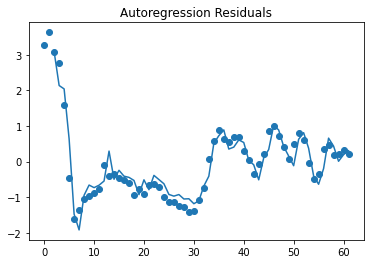

In [212]:
Y_train_autoreg = auto_reg_detrend.predict().reshape(-1,1)

#Plot the residuals
plt.title("Autoregression Residuals")
plt.scatter(X_train_cpi, Residuals_cpi)
plt.plot(X_train_cpi[2:], Y_train_autoreg)

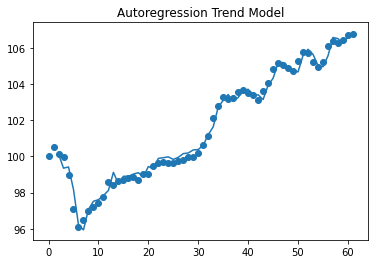

In [179]:
#Plot the AR and Trend Model
Y_train_ART = Y_train_autoreg + Y_predict_cpi[2:]

plt.title("Autoregression Trend Model")
plt.scatter(X_train_cpi, Y_train_cpi)
plt.plot(X_train_cpi[2:], Y_train_ART)

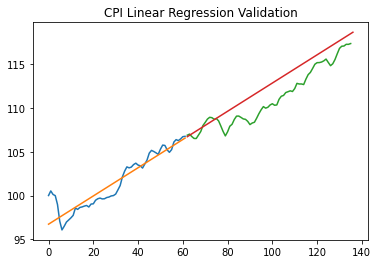

In [194]:
#Filter values to September 2013 and after
price_monthly_df_test = price_monthly_df[price_monthly_df['date'] >= '2013-09-01']

#Reindex the date to monthly periods 
#Reshape the data to numpy arrays for sklearn
X_test_cpi = ((price_monthly_df_test['date'].dt.year - 2008)*12 + price_monthly_df_test['date'].dt.month - 7).values.reshape(-1,1)
Y_test_cpi = price_monthly_df_test['CPI'].values.reshape(-1,1)

#Get the trend predictions for the validation test set
Y_valid_cpi = reg_cpi.predict(X_test_cpi)

#Plot both the training and test set trend
plt.title('CPI Linear Regression Validation')
plt.plot(X_train_cpi, Y_train_cpi)
plt.plot(X_train_cpi, Y_predict_cpi)
plt.plot(X_test_cpi, Y_test_cpi)
plt.plot(X_test_cpi, Y_valid_cpi)

In [272]:
#Reconstruct the continuous train and test series in order index and loop through the 1-month forward predictions
X_train_test = np.append(X_train_cpi, X_test_cpi)
Y_linreg_predict = np.append(Y_predict_cpi, Y_valid_cpi)
Y_train_test = np.append(Y_train_cpi, Y_test_cpi)
Y_train_test_residuals = Y_train_test - Y_linreg_predict

print(Y_train_ART[-1])

#Compare chart with chart above visually check the series
#plt.title('CPI Linear Regression Reconstructed')
#plt.plot(X_train_test, Y_train_test)
#plt.plot(X_train_test, Y_linreg_predict)

#plt.title('CPI Linear Regression Residuals Reconstructed')
#plt.scatter(X_train_test, Y_train_test_residuals)


[106.85927848]


In [282]:

auto_reg_forecast = AutoReg(Y_train_test_residuals, lags=2, trend='n', old_names=False)

#To avoid data leakage, we must build the Residuals for the test set one forecast at a time

#Set the index of the first test set observation to predict
predict_idx=len(X_train_cpi)

#Set the number of test set observations, excluding the last value which is nan
num_forecasts = len(X_test_cpi)
#num_forecasts = 3

#Create an array to hold forecasts
#Backfill the array with previous ART model predictions and prefix it with values of 100 to maintain a consistent index
Y_forecasts = np.array([[100],[100]]) 
Y_forecasts = np.append(Y_forecasts, Y_train_ART, axis=0)

for i in range(predict_idx, predict_idx + num_forecasts):

    Y_AR_predict = auto_reg_forecast.predict(params=auto_reg_detrend.params,start=i, end=i)

    #print('Linear Component:', Y_linreg_predict[i])
    #print('Autoreg Component:', Y_AR_predict)

    Y_ART_predict = Y_linreg_predict[i] + Y_AR_predict
    #print('Lin+AR Component:', Y_ART_predict)
    Y_forecasts = np.append(Y_forecasts, Y_ART_predict)
    
print(Y_forecasts)



Linear Component: 106.71402231623478
Autoreg Component: [0.09638507]
Lin+AR Component: [106.81040739]
Linear Component: 106.87506579990429
Autoreg Component: [0.11708515]
Lin+AR Component: [106.99215095]
Linear Component: 107.03610928357381
Autoreg Component: [0.08565854]
Lin+AR Component: [107.12176782]
Linear Component: 107.19715276724332
Autoreg Component: [-0.47763655]
Lin+AR Component: [106.71951621]
Linear Component: 107.35819625091283
Autoreg Component: [-0.74783137]
Lin+AR Component: [106.61036488]
Linear Component: 107.51923973458234
Autoreg Component: [-0.77016733]
Lin+AR Component: [106.74907241]
Linear Component: 107.68028321825186
Autoreg Component: [-0.36413102]
Lin+AR Component: [107.3161522]
Linear Component: 107.84132670192136
Autoreg Component: [-0.17838859]
Lin+AR Component: [107.66293811]
Linear Component: 108.00237018559088
Autoreg Component: [0.40276127]
Lin+AR Component: [108.40513146]
Linear Component: 108.1634136692604
Autoreg Component: [0.37665753]
Lin+AR Com

In [ ]:
Y_test_autoreg = 

In [291]:
#Split the forecasts back into the train and test set for graphing
Y_test_ART = Y_forecasts[predict_idx:predict_idx + num_forecasts].reshape(-1,1)

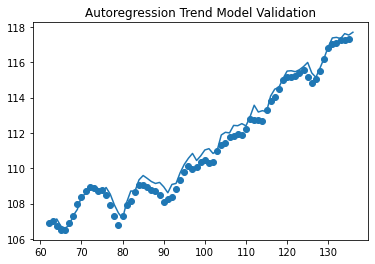

In [292]:
plt.title("Autoregression Trend Model Validation")
plt.scatter(X_test_cpi, Y_test_cpi)
plt.plot(X_test_cpi, Y_test_ART)

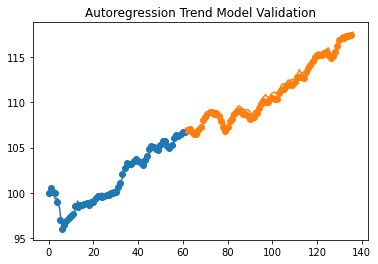

In [293]:


plt.title("Autoregression Trend Model Validation")
plt.scatter(X_train_cpi, Y_train_cpi)
plt.plot(X_train_cpi[2:], Y_train_ART)
plt.scatter(X_test_cpi, Y_test_cpi)
plt.plot(X_test_cpi, Y_test_ART)

In [295]:
#Keep
rmse(Y_test_cpi[:-1], Y_test_ART[:-1], axis=0)

array([0.41950097])

In [82]:
#Plot the rate of inflation and get the value for February 2013
price_monthly_df['CPI_Prev'] = price_monthly_df['CPI'].shift(periods=1, fill_value=100)
price_monthly_df['Inflation'] = (price_monthly_df['CPI'] - price_monthly_df['CPI_Prev'])/price_monthly_df['CPI_Prev']

<ipython-input-82-04e923cee025>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_monthly_df['CPI_Prev'] = price_monthly_df['CPI'].shift(periods=1, fill_value=100)
<ipython-input-82-04e923cee025>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_monthly_df['Inflation'] = (price_monthly_df['CPI'] - price_monthly_df['CPI_Prev'])/price_monthly_df['CPI_Prev']


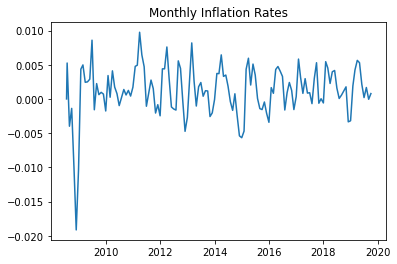

In [83]:
plt.title('Monthly Inflation Rates')
plt.plot(price_monthly_df['date'], price_monthly_df['Inflation'])
print('February 2013 Inflation Rate:', price_monthly_df[price_monthly_df['date']=='2013-02-01']['Inflation'].values)

<ipython-input-111-d7205ccae71f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_monthly_df['Inflation_LN'] = np.log(price_monthly_df['CPI'].values) - np.log(price_monthly_df['CPI_Prev'].values)
February 2013 Ln Inflation Rate: [0.00295287]


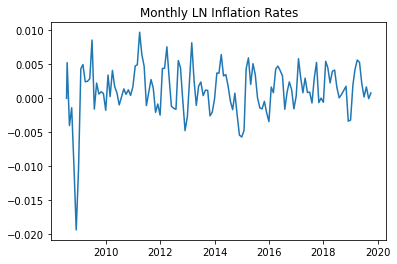

In [111]:
#Plot the LN-based rate of inflation and get the value for February 2013
price_monthly_df['Inflation_LN'] = np.log(price_monthly_df['CPI'].values) - np.log(price_monthly_df['CPI_Prev'].values)
plt.title('Monthly LN Inflation Rates')
plt.plot(price_monthly_df['date'], price_monthly_df['Inflation_LN'])
print('February 2013 Ln Inflation Rate:', price_monthly_df[price_monthly_df['date']=='2013-02-01']['Inflation_LN'].values)


In [124]:
Jan_PS_avg = np.average(price_df[(price_df['date'].dt.month==1) & (price_df['date'].dt.year==2013)]['PriceStats'].values)
Feb_PS_avg = np.average(price_df[(price_df['date'].dt.month==2) & (price_df['date'].dt.year==2013)]['PriceStats'].values)
Feb_PS_avg_inf = (Feb_PS_avg - Jan_PS_avg) / Jan_PS_avg
print('February Average Price Stats Inflation: ', Feb_PS_avg_inf)

February Average Price Stats Inflation:  0.0103586894852065


In [126]:
Jan_PS_last = (price_df[price_df['date']=='2013-01-31']['PriceStats'].values)
Feb_PS_last = (price_df[price_df['date']=='2013-02-28']['PriceStats'].values)
Feb_PS_last_inf = (Feb_PS_last - Jan_PS_last) / Jan_PS_last
print('February Last Price Stats Inflation: ', Feb_PS_last_inf)

February Last Price Stats Inflation:  [0.01159453]


In [135]:
price_df['PriceStats_Prev'] = price_df['PriceStats'].shift(periods=1, fill_value=100)
price_df['PriceStats_Daily_Inf'] = (price_df['PriceStats'] - price_df['PriceStats_Prev'])/price_df['PriceStats_Prev'] 
Feb_PS_daily_inf = np.average(price_df[(price_df['date'].dt.month==2) & (price_df['date'].dt.year==2013)]['PriceStats_Daily_Inf'].values) * 30
print('February Average Daily Price Stats Inflation: ', Feb_PS_daily_inf)


February Average Daily Price Stats Inflation:  0.012355070656994892


In [150]:
BER_df = pd.read_csv('./release_time_series_report_data/T10YIE.csv', header=0)
BER_df['DATE'] = pd.to_datetime(BER_df['DATE'])
BER_df = BER_df.dropna()
BER_df


,DATE,T10YIE
0,2003-01-02,1.64
1,2003-01-03,1.62
2,2003-01-06,1.63
3,2003-01-07,1.62
4,2003-01-08,1.71
...,...,...
4388,2019-10-29,1.61
4389,2019-10-30,1.57
4390,2019-10-31,1.54
4391,2019-11-01,1.59


In [156]:
Feb_BER_avg_ann = np.average(BER_df[(BER_df['DATE'].dt.month==2) & (BER_df['DATE'].dt.year==2013)]['T10YIE'].values)
Feb_BER_avg_mo = (Feb_BER_avg_ann/100 + 1) ** (1/12) -1
print('February Average Break Even Inflation Expectation: ', Feb_BER_avg_mo)

February Average Break Even Inflation Expectation:  0.002104418522466567
